In [348]:
import sys
sys.path.append('/home/kal/K27act_models/cg_model/')
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import precision_recall_curve, roc_curve
import pickle
import cg_annotations

lowercase_map = np.arange(256, dtype=np.uint8)
lowercase_map[np.fromstring("ACGT", dtype=np.uint8)] = np.fromstring("acgt", dtype=np.uint8)

/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [224]:
peaks = pd.read_table('/home/kal/K27act_models/GM_data/merged_annotated.bed', header=None)
peaks.columns='chr narrowstart narrowend name fold_change atac_norm k27act_norm'.split()
peaks['start']= (peaks['narrowend']//2+peaks['narrowstart']//2 - 512)
peaks['end']= (peaks['narrowend']//2+peaks['narrowstart']//2 + 512)
peaks.head()

,chr,narrowstart,narrowend,name,fold_change,atac_norm,k27act_norm,start,end
0,chr1,566683,566939,Peak_1_ENCFF996CVE_dhs,-5.267636,71.997884,0.894933,566298,567322
1,chr1,567449,567705,Peak_2_ENCFF996CVE_dhs,-9.158200,1054.429466,0.847295,567064,568088
2,chr1,569795,570051,Peak_3_ENCFF996CVE_dhs,-8.836435,1683.402523,2.684800,569410,570434
3,chr1,713890,714146,"Peak_19010_ENCFF411MHX_atac,Peak_4a_ENCFF996CV...",-0.280792,38.841973,31.795482,713506,714530
4,chr1,714416,714672,Peak_16416_ENCFF411MHX_atac,0.514744,32.366683,46.672331,714032,715056


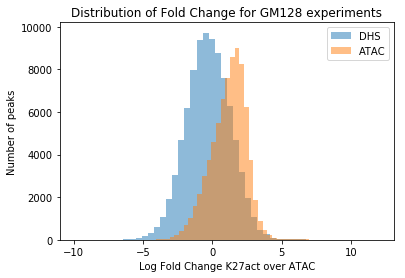

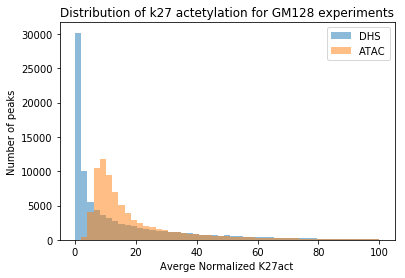

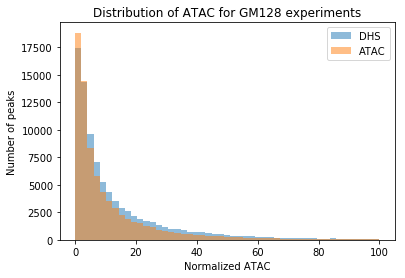

In [358]:
# how should we comine this data?
#bins=np.linspace(0, 50, 50)
bins=50
plt.hist(peaks[['dhs' in n for n in peaks['name']]]['fold_change'], label='DHS', alpha=0.5, bins=bins)
plt.hist(peaks[['atac' in n for n in peaks['name']]]['fold_change'], label='ATAC', alpha=0.5, bins=bins)
plt.ylabel('Number of peaks')
plt.xlabel('Log Fold Change K27act over ATAC')
plt.title('Distribution of Fold Change for GM128 experiments')
plt.legend()
plt.show()

bins=np.linspace(0, 100, 50)
plt.hist(peaks[['dhs' in n for n in peaks['name']]]['k27act_norm'], label='DHS', alpha=0.5, bins=bins)
plt.hist(peaks[['atac' in n for n in peaks['name']]]['k27act_norm'], label='ATAC', alpha=0.5, bins=bins)
plt.ylabel('Number of peaks')
plt.xlabel('Averge Normalized K27act')
plt.title('Distribution of k27 actetylation for GM128 experiments')
plt.legend()
plt.show()

bins=np.linspace(0, 100, 50)
plt.hist(peaks[['dhs' in n for n in peaks['name']]]['atac_norm'], label='DHS', alpha=0.5, bins=bins)
plt.hist(peaks[['atac' in n for n in peaks['name']]]['atac_norm'], label='ATAC', alpha=0.5, bins=bins)
plt.ylabel('Number of peaks')
plt.xlabel('Normalized ATAC')
plt.title('Distribution of ATAC for GM128 experiments')
plt.legend()
plt.show()

In [346]:
# add cg and c.g data
peaks['gc_frac'] = peaks.apply(cg_annotations.gc_frac, axis=1)
peaks['cpg_frac'] = peaks.apply(cg_annotations.cpg_frac, axis=1)

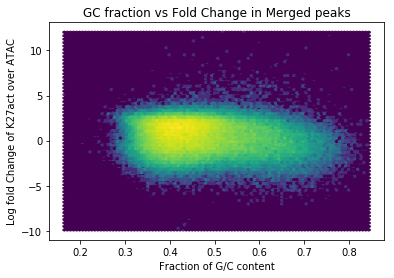

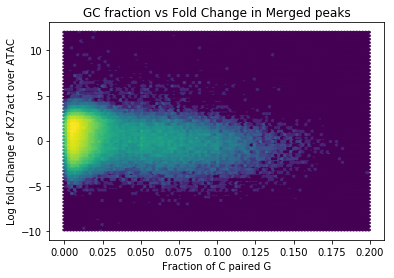

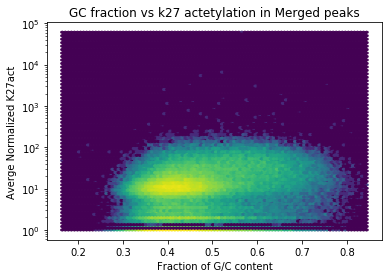

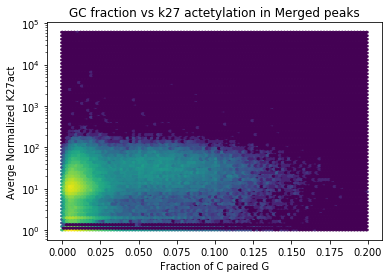

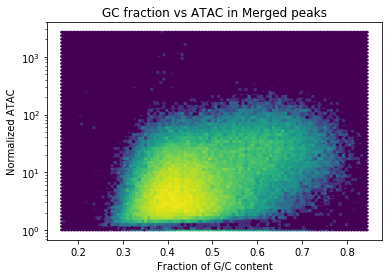

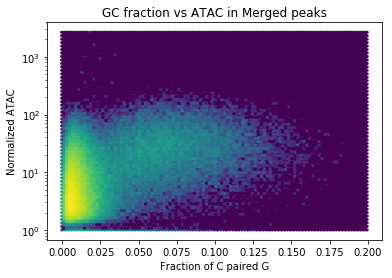

In [368]:
# make some charts
plt.title('GC fraction vs Fold Change in Merged peaks')
plt.ylabel('Log fold Change of K27act over ATAC')
plt.xlabel('Fraction of G/C content')
plt.hexbin(peaks['gc_frac'], peaks['fold_change'], bins='log')
plt.show()

plt.title('GC fraction vs Fold Change in Merged peaks')
plt.ylabel('Log fold Change of K27act over ATAC')
plt.xlabel('Fraction of C paired G')
plt.hexbin(peaks['cpg_frac'], peaks['fold_change'], bins='log')
plt.show()

plt.title('GC fraction vs k27 actetylation in Merged peaks')
plt.ylabel('Averge Normalized K27act')
plt.xlabel('Fraction of G/C content')
plt.hexbin(peaks['gc_frac'], peaks['k27act_norm']+1, bins='log', yscale='log')
plt.show()

plt.title('GC fraction vs k27 actetylation in Merged peaks')
plt.ylabel('Averge Normalized K27act')
plt.xlabel('Fraction of C paired G')
plt.hexbin(peaks['cpg_frac'], peaks['k27act_norm'] +1, bins='log', yscale='log')
plt.show()

plt.title('GC fraction vs ATAC in Merged peaks')
plt.ylabel('Normalized ATAC')
plt.xlabel('Fraction of G/C content')
plt.hexbin(peaks['gc_frac'], peaks['atac_norm']+1, bins='log', yscale='log')
plt.show()

plt.title('GC fraction vs ATAC in Merged peaks')
plt.ylabel('Normalized ATAC')
plt.xlabel('Fraction of C paired G')
plt.hexbin(peaks['cpg_frac'], peaks['atac_norm'] +1, bins='log', yscale='log')
plt.show()

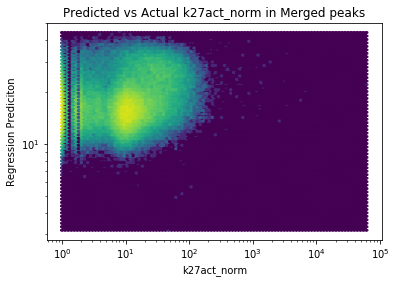

gc_frac coeffs: 45.36993868496295
cpg_frac coeffs: 53.79622905938038
intercept: -5.419891435136908
MSE: 27015.85231771768


In [450]:
predicted_feature='k27act_norm'

# build a regresion model
lm_2 = LinearRegression()
poly_2 = PolynomialFeatures(1, interaction_only=True)
lm_2.fit(peaks[['gc_frac','cpg_frac']], peaks[predicted_feature])

#make a plot
plt.title('Predicted vs Actual {} in Merged peaks'.format(predicted_feature))
plt.xlabel(predicted_feature)
plt.ylabel('Regression Prediciton')
preds_2=lm_2.predict(peaks[['gc_frac','cpg_frac']]).clip(min=0)
if 'norm' in predicted_feature:
    plt.hexbin(peaks[predicted_feature]+1, preds_2+1, bins='log', xscale='log', yscale='log')
else:
    plt.hexbin(peaks[predicted_feature], preds_2, bins='log', extent=(-10, 10, -10, 10))
plt.show()

print('gc_frac coeffs: ' + str(lm_2.coef_[0]))
print('cpg_frac coeffs: ' + str(lm_2.coef_[1]))
print('intercept: ' + str(lm_2.intercept_))

#calculate error
mse_2 = np.mean((peaks[predicted_feature] - preds_2) **2)
print('MSE: ' + str(mse_2))

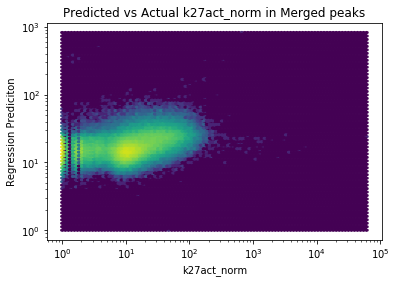

gc_frac coeff: 51.49026016968642
cpg_frac coeff: -61.56657500416292
atac coeff: 0.3044105308284841
intercept: -9.465945922163314
MSE: 26978.268353877622


In [451]:
# build a regresion model
lm_3 = LinearRegression()
lm_3.fit(peaks[['gc_frac','cpg_frac', 'atac_norm']], peaks[predicted_feature])

#make a plot
plt.title('Predicted vs Actual {} in Merged peaks'.format(predicted_feature))
plt.xlabel(predicted_feature)
plt.ylabel('Regression Prediciton')
preds_3=lm_3.predict(peaks[['gc_frac','cpg_frac', 'atac_norm']]).clip(min=0)
if 'norm' in predicted_feature:
    plt.hexbin(peaks[predicted_feature]+1, preds_3+1, bins='log', xscale='log', yscale='log')
else:
    plt.hexbin(peaks[predicted_feature], preds_3, bins='log', extent=(-10, 10, -10, 10))
plt.show()

print('gc_frac coeff: ' + str(lm_3.coef_[0]))
print('cpg_frac coeff: ' + str(lm_3.coef_[1]))
print('atac coeff: ' + str(lm_3.coef_[2]))
print('intercept: ' + str(lm_3.intercept_))

#calculate error
mse_3 = np.mean((peaks[predicted_feature] - preds_3) **2)
print('MSE: ' + str(mse_3))

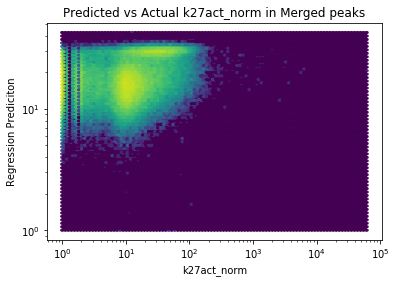

1: 0.0
x0: 50.48246083743675
x1: 985.2702518019605
x0 x1: -1374.4632746085329
gc_frac: x0
cpg_frac: x1
intercept: -11.235602787209736
MSE: 27005.270136682302


In [454]:
# build a regresion model

poly_2i = PolynomialFeatures(2, interaction_only=True)
fit_data = poly_2i.fit_transform(peaks[['gc_frac','cpg_frac']])

lm_2i = LinearRegression()
lm_2i.fit(fit_data, peaks[predicted_feature])

#make a plot
plt.title('Predicted vs Actual {} in Merged peaks'.format(predicted_feature))
plt.xlabel(predicted_feature)
plt.ylabel('Regression Prediciton')
preds_2i=lm_2i.predict(fit_data).clip(min=0)
if 'norm' in predicted_feature:
    plt.hexbin(peaks[predicted_feature]+1, preds_2i+1, bins='log', xscale='log', yscale='log')
else:
    plt.hexbin(peaks[predicted_feature], preds_2i, bins='log', extent=(-10, 10, -10, 10))
plt.show()

for name, co in zip(poly_2i.get_feature_names(), lm_2i.coef_):
    print(name + ': ' + str(co))
print('gc_frac: x0')
print('cpg_frac: x1')
print('intercept: ' + str(lm_2i.intercept_))

#calculate error
mse_2i = np.mean((peaks[predicted_feature] - preds_2i) **2)
print('MSE: ' + str(mse_2i))

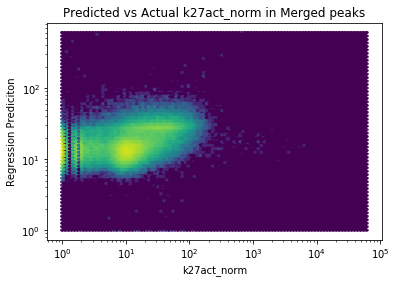

1: 0.0
x0: 22.965008865522186
x1: 750.231242845271
x2: -0.6517708745523088
x0 x1: -939.3422629024884
x0 x2: 2.7972873042829534
x1 x2: -11.661895722815762
gc_frac: x0
cpg_frac: x1
atac: x2
intercept: -2.696546262496451
MSE: 26961.530998930037


In [455]:
# build a regresion model

poly_3i = PolynomialFeatures(2, interaction_only=True)
fit_data = poly_3i.fit_transform(peaks[['gc_frac','cpg_frac', 'atac_norm']])

lm_3i = LinearRegression()
lm_3i.fit(fit_data, peaks[predicted_feature])

#make a plot
plt.title('Predicted vs Actual {} in Merged peaks'.format(predicted_feature))
plt.xlabel(predicted_feature)
plt.ylabel('Regression Prediciton')
preds_3i=lm_3i.predict(fit_data).clip(min=0)
if 'norm' in predicted_feature:
    plt.hexbin(peaks[predicted_feature]+1, preds_3i+1, bins='log', xscale='log', yscale='log')
else:
    plt.hexbin(peaks[predicted_feature], preds_3i, bins='log', extent=(-10, 10, -10, 10))
plt.show()

for name, co in zip(poly_3i.get_feature_names(), lm_3i.coef_):
    print(name + ': ' + str(co))
print('gc_frac: x0')
print('cpg_frac: x1')
print('atac: x2')
print('intercept: ' + str(lm_3i.intercept_))

#calculate error
mse_3i = np.mean((peaks[predicted_feature] - preds_3i) **2)
print('MSE: ' + str(mse_3i))

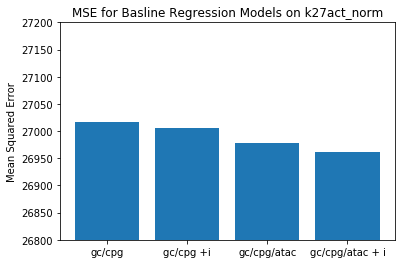

In [456]:
plt.bar([1,2,3,4], [mse_2, mse_2i, mse_3, mse_3i])
plt.xticks([1, 2, 3, 4], ['gc/cpg', 'gc/cpg +i', 'gc/cpg/atac', 'gc/cpg/atac + i'])
plt.title('MSE for Basline Regression Models on ' + predicted_feature)
plt.ylabel('Mean Squared Error')
if 'norm' in predicted_feature:
    plt.ylim(26800, 27200)
plt.show()

In [397]:
pickle.dump(lm_2, open('cg_cpg_regression_{}.pk'.format(predicted_feature), 'wb'))
pickle.dump(lm_2i, open('cg_cpg_i_regression_{}.pk'.format(predicted_feature), 'wb'))
pickle.dump(lm_3, open('cg_cpg_atac_regression_{}.pk'.format(predicted_feature), 'wb'))
pickle.dump(lm_3i, open('cg_cpg_atac_i_regression_{}.pk'.format(predicted_feature), 'wb'))

In [457]:
if predicted_feature == 'k27act_norm':
    preds_2 = np.log2((preds_2+1)/(peaks['atac_norm']+1))
    preds_3 = np.log2((preds_3+1)/(peaks['atac_norm']+1))
    preds_2i = np.log2((preds_2i+1)/(peaks['atac_norm']+1))
    preds_3i = np.log2((preds_3i+1)/(peaks['atac_norm']+1))

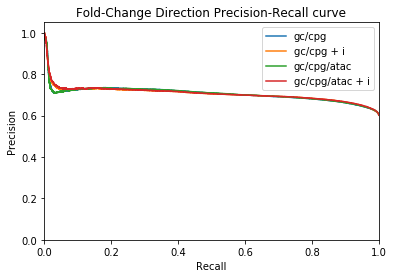

In [458]:
# pr curve
p_2, r_2, t = precision_recall_curve(peaks['fold_change']>0, preds_2)
p_2i, r_2i, t = precision_recall_curve(peaks['fold_change']>0, preds_2i)
p_3, r_3, t = precision_recall_curve(peaks['fold_change']>0, preds_3)
p_3i, r_3i, t = precision_recall_curve(peaks['fold_change']>0, preds_3i)


plt.plot(r_2, p_2, label='gc/cpg')
plt.plot(r_2i, p_2i, label='gc/cpg + i')
plt.plot(r_3, p_3, label='gc/cpg/atac')
plt.plot(r_3i, p_3i, label='gc/cpg/atac + i')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend()
plt.title('Fold-Change Direction Precision-Recall curve')
plt.show()

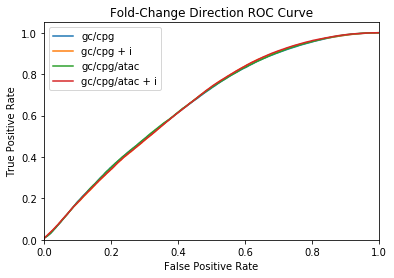

In [459]:
# roc curve
fpr_2, tpr_2, t = roc_curve(peaks['fold_change']>0, preds_2)
fpr_2i, tpr_2i, t = roc_curve(peaks['fold_change']>0, preds_2i)
fpr_3, tpr_3, t = roc_curve(peaks['fold_change']>0, preds_3)
fpr_3i, tpr_3i, t = roc_curve(peaks['fold_change']>0, preds_3i)


plt.plot(fpr_2, tpr_2, label='gc/cpg')
plt.plot(fpr_2i, tpr_2i, label='gc/cpg + i')
plt.plot(fpr_3, tpr_3, label='gc/cpg/atac')
plt.plot(fpr_3i, tpr_3i, label='gc/cpg/atac + i')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend()
plt.title('Fold-Change Direction ROC Curve')
plt.show()

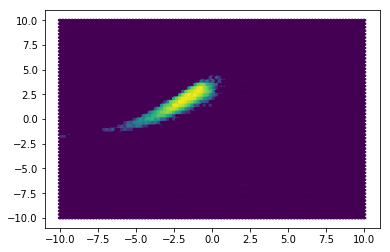

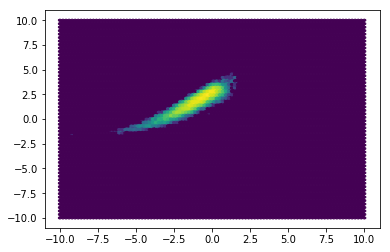

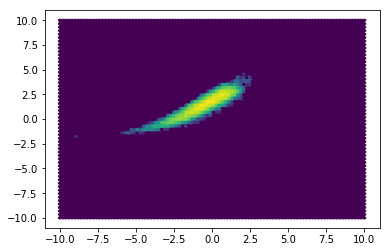

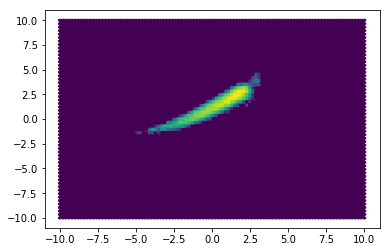

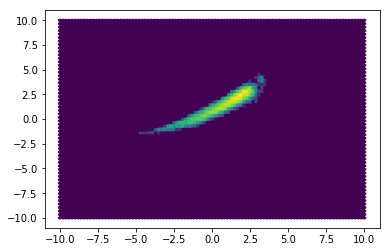

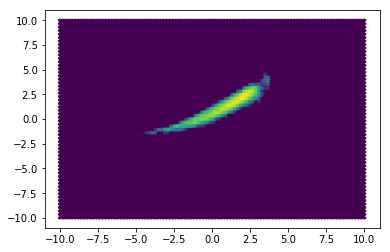

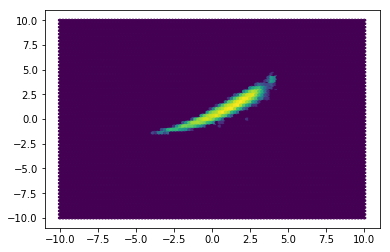

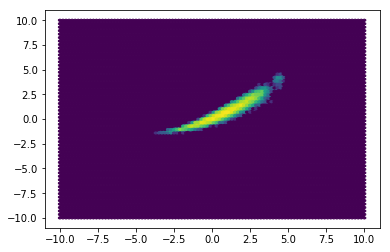

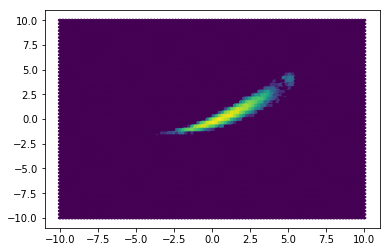

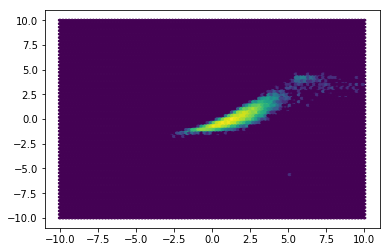

In [465]:
# stratefied hexbins
model = lm_2
poly = poly_2
num_groups = 10
split_column = 'k27act_norm'

mse=dict()
p=dict()
r=dict()
fpr=dict()
tpr=dict()
names=dict()

for i in range(num_groups):
    # get quintile values
    min_fold, max_fold = peaks.quantile([i/num_groups, (i+1)/num_groups])[split_column]
    names[i]='{:.2}-{:.2}'.format(min_fold, max_fold)
    subset_peaks = peaks[(peaks[split_column] >= min_fold) & (peaks[split_column] < max_fold)]
    fit_data = subset_peaks[['gc_frac','cpg_frac']]
    preds = model.predict(fit_data)
    if predicted_feature == 'k27act_norm':
        preds = np.log2((preds+1)/(subset_peaks['atac_norm']+1))
    
    #make a plot
    plt.hexbin(subset_peaks['fold_change'], preds, bins='log', extent=(-10, 10, -10, 10))
    plt.show()

    #calculate error
    mse[i] = np.mean((subset_peaks['fold_change'] - preds) **2)
    p[i], r[i], t = precision_recall_curve(subset_peaks['fold_change']>0, preds)
    fpr[i], tpr[i], t = roc_curve(subset_peaks['fold_change']>0, preds)

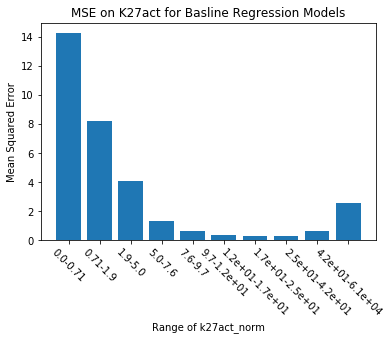

In [466]:
# make an mse plot
plt.bar(range(num_groups), mse.values())
plt.xticks(range(num_groups), names.values(), rotation=-45)
plt.xlabel('Range of {}'.format(split_column))
plt.title('MSE on K27act for Basline Regression Models')
plt.ylabel('Mean Squared Error')
plt.show()

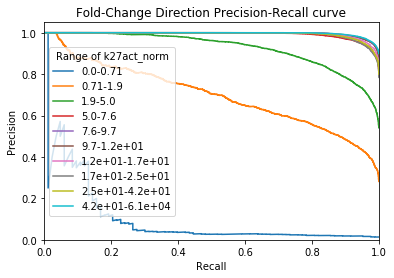

In [467]:
for i in range(num_groups):
    plt.plot(r[i], p[i], label=names[i])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(title='Range of {}'.format(split_column))
plt.title('Fold-Change Direction Precision-Recall curve')
plt.show()

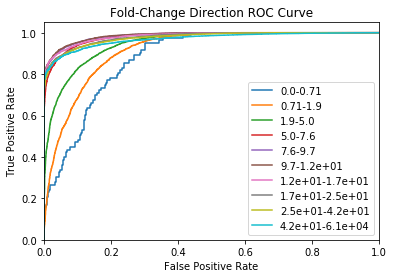

In [468]:
for i in range(num_groups):
    plt.plot(fpr[i], tpr[i], label=names[i])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend()
plt.title('Fold-Change Direction ROC Curve')
plt.show()